In [16]:
import pandas as pd


import seaborn as sns
sns.set_theme(palette='BuPu_r')

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('trustpilot_reviews.csv')
df['date_experience'] = pd.to_datetime(df['date_experience'])
df.head()

,review_title,cust_name,cust_location,cust_reviews,cust_rating,cust_review_text,seller_response,date_experience
0,PERFECTION,Ellen Feibel,US,3,5,First: you had the books I wanted for a gift t...,False,2024-12-14
1,Good book buying experience,Randy,US,2,5,Great communication about my order. Books arri...,False,2024-12-14
2,I appreciate the selection and the…,Nana,US,3,5,I appreciate the selection and the prices of t...,False,2024-12-13
3,The books arrived in a very timely…,customer,US,1,5,The books arrived in a very timely fashion and...,False,2024-12-14
4,"Quick delivery, fab products",customer,GB,8,5,Beautiful books delivered extremely quickly co...,False,2024-12-16


In [4]:
df.dtypes

review_title                object
cust_name                   object
cust_location               object
cust_reviews                 int64
cust_rating                  int64
cust_review_text            object
seller_response               bool
date_experience     datetime64[ns]
dtype: object

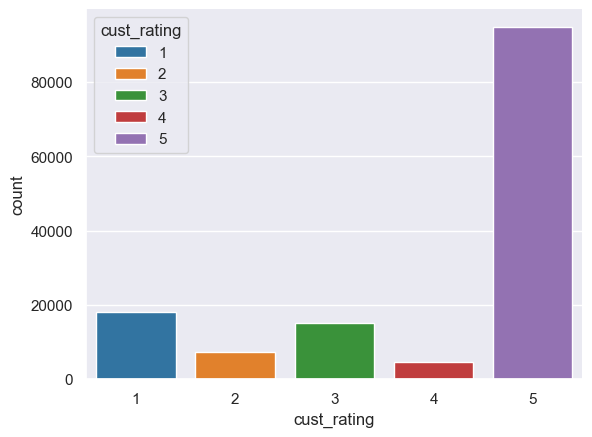

In [22]:
sns.countplot(x='cust_rating', data=df, hue='cust_rating', palette='tab10')
sns.despine()
plt.show()

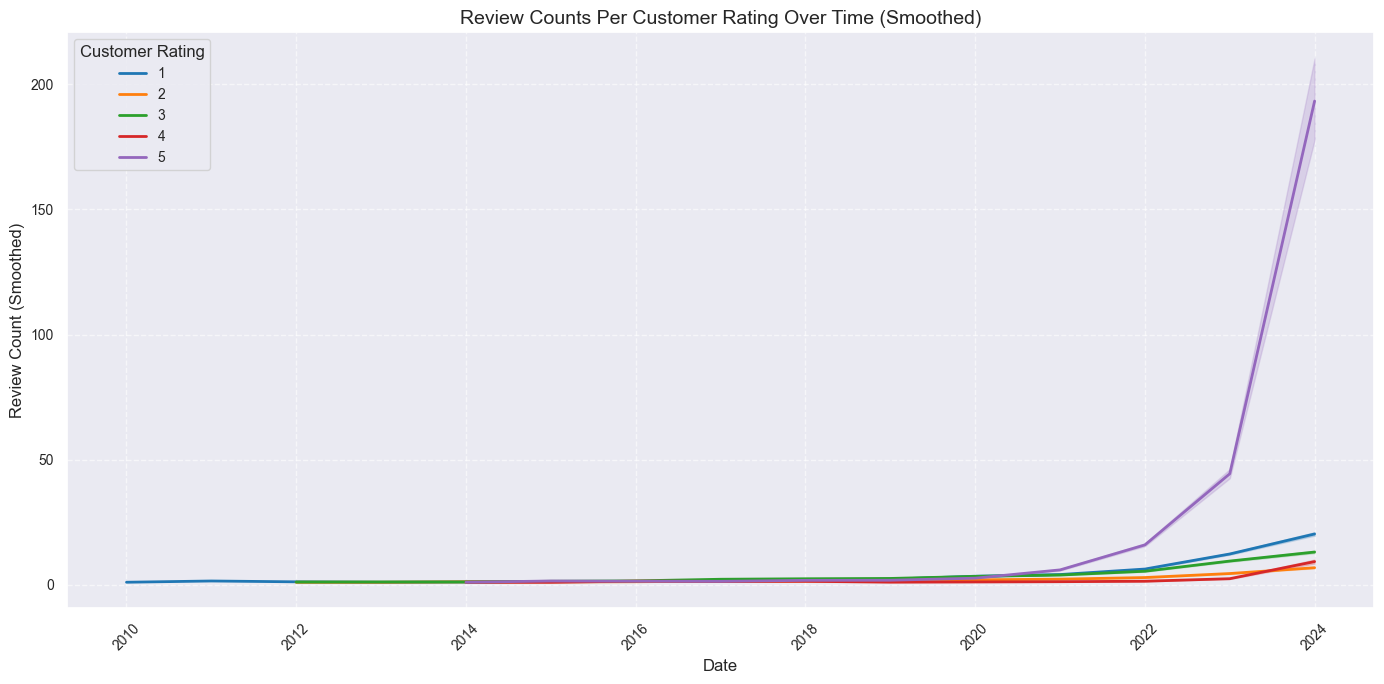

In [19]:
review_counts = df.groupby(['date_experience', 'cust_rating']).size().reset_index(name='review_count')


review_counts['date_experience'] = review_counts['date_experience'].dt.to_period('Y').dt.to_timestamp()

# Smooth data using a rolling average (optional, depends on dataset size)
review_counts['review_count_smoothed'] = review_counts.groupby('cust_rating')['review_count'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Create the line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count_smoothed',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count (Smoothed)', fontsize=12)
plt.title('Review Counts Per Customer Rating Over Time (Smoothed)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

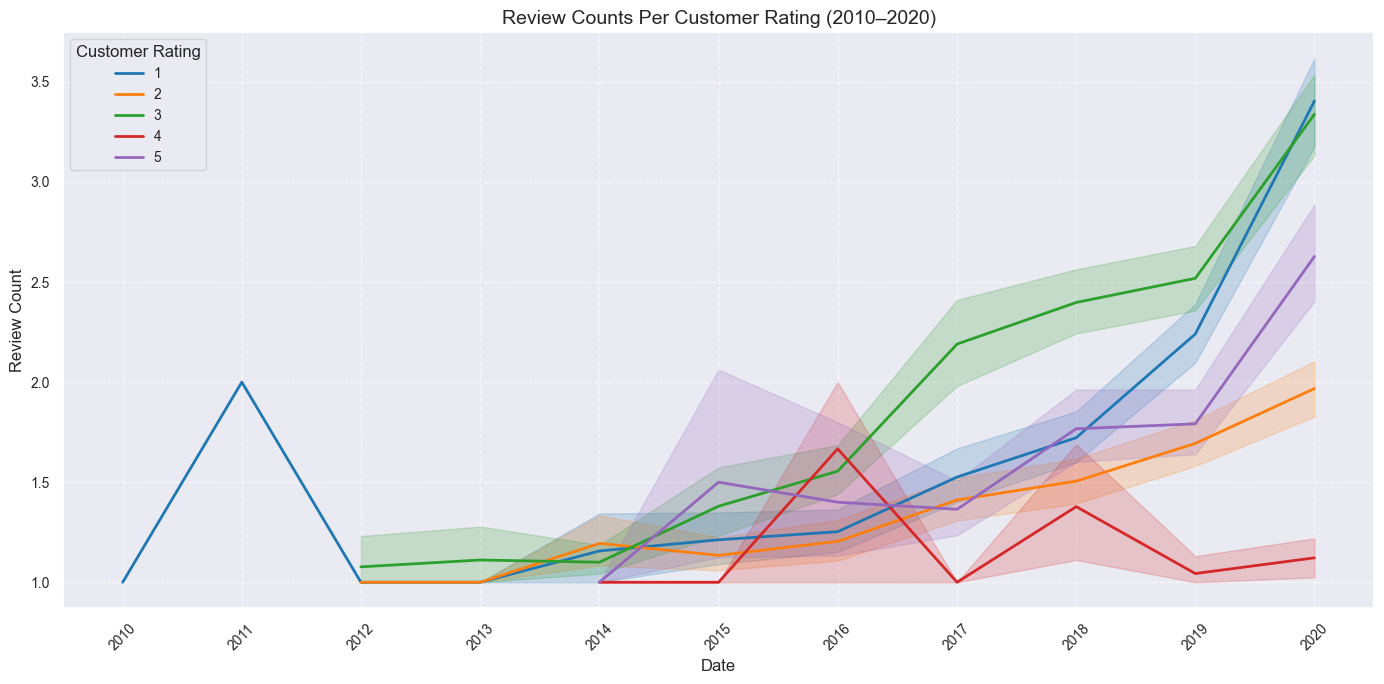

In [21]:
review_counts = review_counts[
    (review_counts['date_experience'] >= '2010-01-01') & (review_counts['date_experience'] <= '2020-12-31')
]

# Create the line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Counts Per Customer Rating (2010–2020)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
review_counts = review_counts[
    (review_counts['date_experience'] >= '2020-01-01') & (review_counts['date_experience'] <= '2020-12-31')
]

# Create the line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Counts Per Customer Rating (2010–2020)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
review_counts.shape

(4881, 4)

In [15]:
filtered_data = df[
    (df['date_experience'] >= '2012-01-01') & (df['date_experience'] <= '2020-12-31')
]


sns.set_theme(palette='BuPu_r')

sns.displot(
    filtered_data,
    x="date_experience",
    col="species",
    row="sex",
    hue="cust_rating",
    binwidth=3,
    height=3,
    facet_kws=dict(margin_titles=True),
)

plt.show()

ValueError: Could not interpret value `sex` for `row`. An entry with this name does not appear in `data`.

<Axes: xlabel='date_experience', ylabel='review_count'>

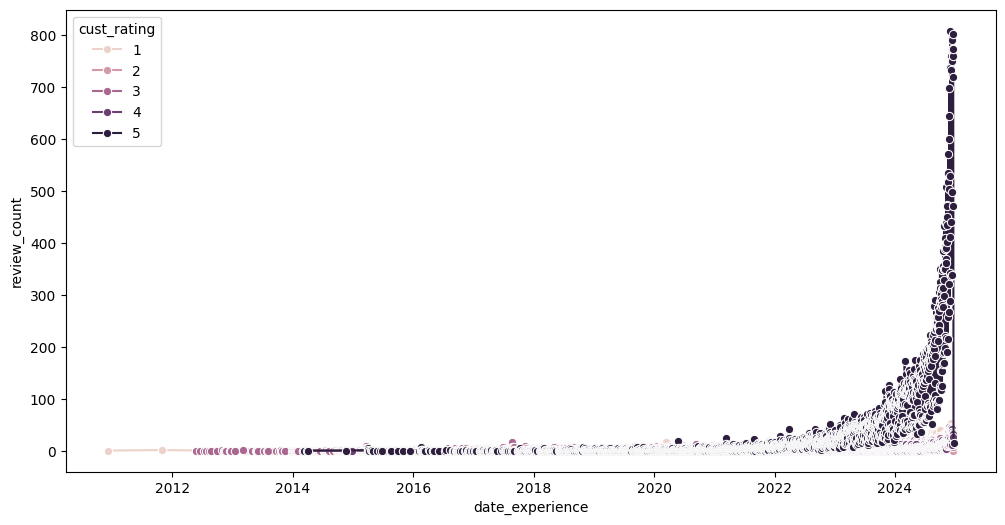

In [8]:
review_counts = df.groupby(['date_experience', 'cust_rating']).size().reset_index(name='review_count')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count',
    hue='cust_rating',
    marker='o'
)